<a href="https://colab.research.google.com/github/asravankumar/END2.0/blob/master/session_5/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Loaders to Download, Preprocess & Create Training/Validation DataSet**

The data is a set of Rotten Tomatoes Movie Reviews labelled and provided readily by stanford.
The raw data is available in two formats
- raw csv files.
- Penn Treebank(PTB tree) format.

The raw csv files contains list of files which consists of list of 
- sentences
- phrases
- trees mapping sentences and phrases
- sentiment of each phrase.

The PTB format consists of the sentences, and the respective phrases in tree format.

In order to get the sentiment of each sentences, we need to parse the tree structure. [pytreebank](https://github.com/JonathanRaiman/pytreebank)  does the job effectively.

We download the sentences and sentiments from [pytreebank](https://github.com/JonathanRaiman/pytreebank) and build models.

**Data Download to CSV File**

In [ ]:
!pip install pytreebank

Stanford Sentiment Treebank Data splits into train, dev and test sets. We therefore maintain the split as given by them.

In [ ]:
import pytreebank
dataset = pytreebank.load_sst()

for category in ['train', 'test', 'dev']:
  out_file = open('sentences_{}.txt'.format(category), 'w')
  out_file.write('{}\t{}\n'.format("sentence", "labels"))
  for item in dataset[category]:
    label, sentence = item.to_labeled_lines()[0]
    out_file.write("{}\t{}\n".format(sentence, label))
  out_file.close()

In [ ]:
import pandas as pd
# create training and validation pandas dataframes from downloaded data.

train_df = pd.read_csv('sentences_train.txt', delimiter='\t')
valid_df = pd.read_csv('sentences_dev.txt', delimiter='\t')

In [ ]:
print("training df shape", train_df.shape)
print("validation df shape", valid_df.shape)


training df shape (8544, 2)
validation df shape (1101, 2)


In [ ]:
train_df['labels'].value_counts()

3    2322
1    2218
2    1624
4    1288
0    1092
Name: labels, dtype: int64

**Understanding our Dataset**

We plot a bar graph on our training data.

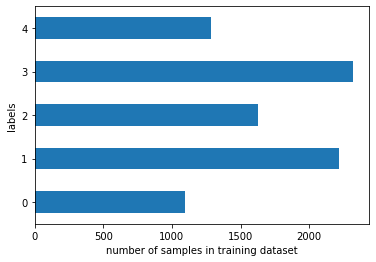

In [ ]:
import matplotlib.pyplot as plt

ax = train_df['labels'].value_counts(sort=False).plot(kind='barh')
ax.set_ylabel("labels")
ax.set_xlabel("number of samples in training dataset")
plt.savefig('value_counts.png')

We clearly can see there is an **imbalance** in the data w.r.t number of samples for each label. 

labels 1,2,3 have more samples than 0 and 4. 

We need to augment some data in labels 0 and 4 to balance them.


### **Data Augmentation**



**- Back Translate**

In [ ]:
!pip install googletrans
!pip install google_trans_new

     |████████████████████████████████| 61kB 3.6MB/s 
     |████████████████████████████████| 1.0MB 8.4MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp37-none-any.whl size=15737 sha256=fdffbb37bf98d3280fbb88c132395cdc3fbf98b144072b5fa711a466fba4d13b
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
Successfully built googletrans


In [ ]:
import random
import googletrans, google_trans_new

translator = google_trans_new.google_translator()

def back_translate(sentence):
  available_languages = list(googletrans.LANGUAGES.keys()) 
  selected_language = random.choice(available_languages) 
  translations = translator.translate(sentence, lang_tgt=selected_language) 
  back_translated_text = translator.translate(translations, lang_src=selected_language, lang_tgt='en') 
  return back_translated_text

In [ ]:
back_translate("training the model")

'Model training '

**- Random Swap**

In [ ]:
def random_swap(sentence, n=5): 
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

In [ ]:
random_swap("training the model".split(' '), 1)

['model', 'the', 'training']

**- Random Deletion**

In [ ]:
def random_deletion(words, p=0.5): 
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return remaining

In [ ]:
random_deletion("training the model".split(' '), 0.2)

['training', 'the', 'model']

## **Augmenting our Data**

We shall augment the datasets based on the above three techniques

As we can see from the data, the labels 0 and 4 are less than that of others, we shall back translate few random samples and populate these.

The other two techniques are applied for random sentences from 1,2,3 labels. 

In [ ]:
train_df

,sentence,labels
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Singer/composer Bryan Adams contributes a slew...,3
3,You 'd think by now America would have had eno...,2
4,Yet the act is still charming here .,3
...,...,...
8539,A real snooze .,0
8540,No surprises .,1
8541,We 've seen the hippie-turned-yuppie plot befo...,3
8542,Her fans walked out muttering words like `` ho...,0


In [ ]:
train_df.loc[7163]

sentence    Collapses after 30 minutes into a slap-happy s...
labels                                                      0
Name: 7163, dtype: object

In [ ]:
def back_translate_sentences_based_on_label(label, new_sentences_count):
  label_indexes = train_df[train_df['labels'] == label].index.tolist()
  selected_indexes = random.sample(label_indexes, new_sentences_count)
  new_label_sentences = []
  for index in selected_indexes:
    sentence = train_df.loc[index].sentence
    back_translated_sentence = back_translate(sentence)
    new_label_sentences.append([back_translated_sentence, label])
  new_df = pd.DataFrame(new_label_sentences, columns=['sentence', 'labels'])
  return(new_df)

new_label_0_df = back_translate_sentences_based_on_label(0, 400)
new_label_1_df = back_translate_sentences_based_on_label(4, 200)

In [ ]:
new_augmented_train_df = pd.concat([train_df, new_label_0_df, new_label_1_df], ignore_index=True)

In [ ]:
new_augmented_train_df.labels.value_counts()

3    2322
1    2218
2    1624
0    1492
4    1488
Name: labels, dtype: int64

Let's augment using random_swap on rest of the labels 1,2,3

In [ ]:
def random_swap_sentences_on_labels(temp_df, label, count):
  label_indexes = temp_df[temp_df['labels'] == label].index.tolist()
  selected_indexes = random.sample(label_indexes, count)
  #print("selected_indexes", selected_indexes)
  for index in selected_indexes:
    sentence = temp_df.loc[index].sentence
    #print("index", index, "sentence", sentence)
    new_sentence = random_swap(sentence.split(' '), 2)
    temp_df.loc[index].sentence = new_sentence
  return(temp_df)

temp_df = new_augmented_train_df.copy()
temp_df = random_swap_sentences_on_labels(temp_df, 1, 100)
temp_df = random_swap_sentences_on_labels(temp_df, 2, 100)
temp_df = random_swap_sentences_on_labels(temp_df, 3, 150)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
def random_delete_sentences_on_labels(temp_df, label, count):
  label_indexes = temp_df[temp_df['labels'] == label].index.tolist()
  selected_indexes = random.sample(label_indexes, count)
  #print("selected_indexes", selected_indexes)
  for index in selected_indexes:
    sentence = temp_df.loc[index].sentence
    #print("index", index, "sentence", sentence)
    new_sentence = random_deletion(sentence.split(' '), 2)
    temp_df.loc[index].sentence = new_sentence
  return(temp_df)

temp_df = temp_df.copy()
temp_df = random_swap_sentences_on_labels(temp_df, 1, 100)
temp_df = random_swap_sentences_on_labels(temp_df, 1, 100)
temp_df = random_swap_sentences_on_labels(temp_df, 1, 150)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
new_train_df = temp_df

In [ ]:
new_train_df

,sentence,labels
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Singer/composer Bryan Adams contributes a slew...,3
3,You 'd think by now America would have had eno...,2
4,Yet the act is still charming here .,3
...,...,...
9139,The Chamber of Secrets will find millions of e...,4
9140,See it.,4
9141,"As a movie, tracking MR. Brown's sports exploi...",4
9142,Completely thrown to the best.,4


In [ ]:
new_train_df.labels.value_counts()

3    2322
1    2218
2    1624
0    1492
4    1488
Name: labels, dtype: int64

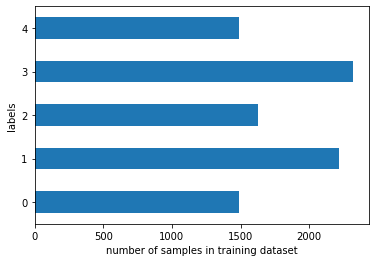

In [ ]:
import matplotlib.pyplot as plt

ax = new_train_df['labels'].value_counts(sort=False).plot(kind='barh')
ax.set_ylabel("labels")
ax.set_xlabel("number of samples in training dataset")

plt.savefig('value_counts_after_aug.png')

**Creating TorchDataSets**

The steps includes preprocessing all the sentences and creating torchtext Dataset objects for the model to use. 

The following preprocessing have been performed:
- lower case all sentences
- remove stopwords


In [ ]:
import torch, torchtext
from torchtext import data

SEED = 12
torch.manual_seed(SEED)

In [ ]:
# The list of stop words which are to be removed from training and validation set.
# The list is from nltk package.
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
Sentence  = torchtext.legacy.data.Field(
                  sequential = True,
                  tokenize = 'spacy',
                  batch_first =True,
                  include_lengths=True,
                  lower=True,
                  stop_words=stop_words)

Label     = torchtext.legacy.data.LabelField(
                  tokenize = 'spacy',
                  is_target = True,
                  batch_first = True,
                  sequential = False)
fields = [('sentence', Sentence),('labels',Label)]
train_example = [ torchtext.legacy.data.Example.fromlist([new_train_df.sentence[i], new_train_df.labels[i]], fields) for i in range(1, new_train_df.shape[0])]
valid_example = [ torchtext.legacy.data.Example.fromlist([valid_df.sentence[i], valid_df.labels[i]], fields) for i in range(1, valid_df.shape[0])]
train_dataset = torchtext.legacy.data.Dataset(train_example, fields)
valid_dataset = torchtext.legacy.data.Dataset(valid_example, fields)

We limit the vocab to 8000 tokens.

In [ ]:
Sentence.build_vocab(train_dataset, max_size=8000)
Label.build_vocab(train_dataset, max_size=8000)

In [38]:
print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appeared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  8002
Size of label vocab :  5
Top 10 words appeared repeatedly : [('.', 8607), (',', 7658), ('-', 2871), ("'s", 2604), ('film', 1241), ('movie', 1099), ('`', 819), ("n't", 694), ('...', 692), ('one', 617)]
Labels :  defaultdict(None, {3: 0, 1: 1, 2: 2, 0: 3, 4: 4})


**Check the device used**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [39]:
train_iterator, valid_iterator = torchtext.legacy.data.BucketIterator.splits((train_dataset, valid_dataset), batch_size = 32, 
                                                            sort_key = lambda x: len(x.sentence),
                                                            sort_within_batch=True, device = device)

In [52]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Sentence.vocab.stoi, tokens)

**Training**

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [41]:
# Define hyperparameters
size_of_vocab = len(Sentence.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 5
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [42]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(8002, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)
The model has 2,642,705 trainable parameters


In [43]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [44]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.sentence   
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()
        
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [45]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [47]:
N_EPOCHS = 50
best_valid_loss = float('inf')
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 1.360 | Train Acc: 56.27%
	 Val. Loss: 1.529 |  Val. Acc: 33.96% 

	Train Loss: 1.305 | Train Acc: 63.72%
	 Val. Loss: 1.536 |  Val. Acc: 33.63% 

	Train Loss: 1.257 | Train Acc: 68.48%
	 Val. Loss: 1.538 |  Val. Acc: 34.26% 

	Train Loss: 1.213 | Train Acc: 72.54%
	 Val. Loss: 1.530 |  Val. Acc: 34.76% 

	Train Loss: 1.175 | Train Acc: 76.01%
	 Val. Loss: 1.528 |  Val. Acc: 35.39% 

	Train Loss: 1.144 | Train Acc: 79.01%
	 Val. Loss: 1.542 |  Val. Acc: 34.61% 

	Train Loss: 1.119 | Train Acc: 80.97%
	 Val. Loss: 1.539 |  Val. Acc: 33.90% 

	Train Loss: 1.098 | Train Acc: 82.56%
	 Val. Loss: 1.543 |  Val. Acc: 33.90% 

	Train Loss: 1.083 | Train Acc: 83.86%
	 Val. Loss: 1.544 |  Val. Acc: 33.93% 

	Train Loss: 1.071 | Train Acc: 84.91%
	 Val. Loss: 1.551 |  Val. Acc: 32.56% 

	Train Loss: 1.058 | Train Acc: 85.92%
	 Val. Loss: 1.548 |  Val. Acc: 33.63% 

	Train Loss: 1.048 | Train Acc: 86.67%
	 Val. Loss: 1.551 |  Val. Acc: 33.72% 

	Train Loss: 1.041 | Train Acc: 87.27%
	

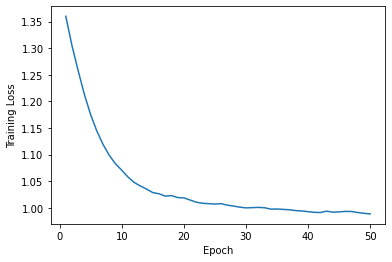

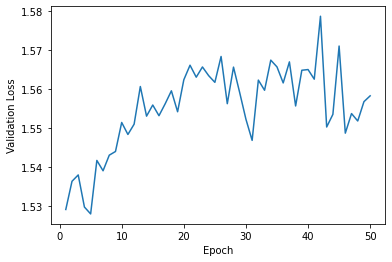

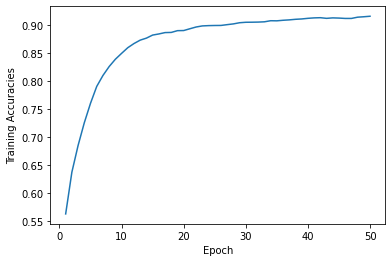

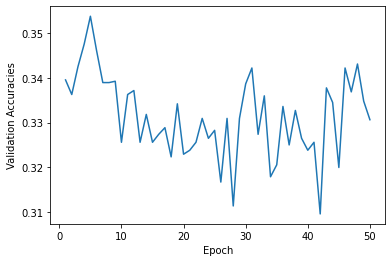

In [50]:
import matplotlib.pyplot as plt

plt.plot(list(range(1, len(train_losses) + 1)), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('training_loss.png')
plt.show()

plt.plot(list(range(1, len(valid_losses) + 1)), valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('valid_loss.png')
plt.show()

plt.plot(list(range(1, len(train_accuracies) + 1)), train_accuracies, label="Training Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracies")
plt.savefig('training_accuracies.png')
plt.show()

plt.plot(list(range(1, len(valid_accuracies) + 1)), valid_accuracies, label="Valid Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracies")
plt.savefig('validation_accuracies.png')
plt.show()

In [74]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet):
    
    categories = {0: "Very Negative", 1:"Negative", 2:"Neutral", 3: "Positive", 4: "Very Positive"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return pred.item(), categories[pred.item()]

In [75]:
classify_tweet("It is an awesome movie.")

(3, 'Positive')

In [77]:
valid_df

,sentence,labels
0,It 's a lovely film with lovely performances b...,3
1,"No one goes unindicted here , which is probabl...",2
2,And if you 're not nearly moved to tears by a ...,3
3,"A warm , funny , engaging film .",4
4,Uses sharp humor and insight into human nature...,4
...,...,...
1096,it seems to me the film is about the art of ri...,1
1097,It 's just disappointingly superficial -- a mo...,1
1098,The title not only describes its main characte...,1
1099,Sometimes it feels as if it might have been ma...,2


In [79]:
index = 987
print("sentence:", valid_df.loc[index].sentence)
print("label:", valid_df.loc[index].labels)
label, category = classify_tweet(valid_df.loc[index].sentence)
print("Predicted Label: ", label, category)

sentence: The overall effect is less like a children 's movie than a recruitment film for future Hollywood sellouts .
label: 1
Predicted Label:  1 Negative


In [100]:
index = 750
print("sentence:", valid_df.loc[index].sentence)
print("label:", valid_df.loc[index].labels)
label, category = classify_tweet(valid_df.loc[index].sentence)
print("Predicted Label: ", label, category)

sentence: It 's difficult to imagine the process that produced such a script , but here 's guessing that spray cheese and underarm noises played a crucial role .
label: 0
Predicted Label:  0 Very Negative


In [131]:
index = 332
print("sentence:", valid_df.loc[index].sentence)
print("label:", valid_df.loc[index].labels)
label, category = classify_tweet(valid_df.loc[index].sentence)
print("Predicted Label: ", label, category)

sentence: What Time Is It There ?
label: 2
Predicted Label:  2 Neutral


**Future Enhancements**

- Use better Data Augmentation Techniques.
- Train using other models like bi-lstm and GRU.